In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(color_codes=True)

In [2]:
df = pd.read_csv("train_data.csv")
display(
    df.shape,
    df.head(),
    df.info(),
    df.nunique(),
    df.isna().sum()
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2266586 entries, 0 to 2266585
Data columns (total 6 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   userID            int64 
 1   assessmentItemID  object
 2   testId            object
 3   answerCode        int64 
 4   Timestamp         object
 5   KnowledgeTag      int64 
dtypes: int64(3), object(3)
memory usage: 103.8+ MB


(2266586, 6)

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225


None

userID                 6698
assessmentItemID       9454
testId                 1537
answerCode                2
Timestamp           2076774
KnowledgeTag            912
dtype: int64

userID              0
assessmentItemID    0
testId              0
answerCode          0
Timestamp           0
KnowledgeTag        0
dtype: int64

### 데이터의 shape는 (2266586, 6)이며, userID, assessmentItemID, testId, Timestamp, KnowledgeTag, answerCode로 이루어져 있다.
##### Train 데이터셋은 6698명의 유저가 풀이한 912개의 대분류(KnowledgeTag), 1537개의 문제지(testId), 9454개의 문항(assessmentItemID)에 대한 정답 유무(answerCode)와 문제풀이 시간(Timestamp)으로 구성되어 있다.

In [3]:
df.describe()

,userID,answerCode,KnowledgeTag
count,2.266586e+06,2.266586e+06,2.266586e+06
mean,2.087687e+03,6.543784e-01,4.909007e+03
std,1.589365e+03,4.755706e-01,3.302214e+03
min,0.000000e+00,0.000000e+00,2.300000e+01
25%,8.000000e+02,0.000000e+00,1.931000e+03
50%,1.748000e+03,1.000000e+00,5.258000e+03
75%,3.046000e+03,1.000000e+00,7.913000e+03
max,7.441000e+03,1.000000e+00,1.127100e+04


In [4]:
df[~df.testId.str.startswith("A") | ~df.assessmentItemID.str.startswith("A")]


,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag


In [5]:
df.testId.apply(lambda x:x[4:7]).unique()


array(['000'], dtype=object)

In [6]:
(df.assessmentItemID.apply(lambda x:x[1:4]) == df.testId.apply(lambda x:x[1:4])).sum()


2266586

In [7]:
(df.assessmentItemID.apply(lambda x:x[4:7]) == df.testId.apply(lambda x:x[7:])).sum()


2266586

##### 편의상 몇가지 전처리를 수행한다. 
- Timestamp는 datetime 형태로 변경하여 날짜, 시간 별 데이터를 확인할 수 있도록 한다.
- testId, assessmentItemID의 모든 데이터는 A로 시작함을 알 수 있고, 첫 세자리가 모두 동일하며 testId의 7~10과 assessmentItemID의 중간 세자리가 동일하다. 또한 testId의 4~7까지의 데이터는 모두 000이다. assessmentItemID는 세자리 단위로 끊겨져 있음을 추측할 수 있으므로 3자리씩 끊어서 미리 저장해 둔다.


In [8]:
percentile = lambda x: np.sum(x).len(x)

In [9]:
df["datetime"] = df.Timestamp.apply(lambda x:datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))

In [10]:
df["year"] = df.datetime.dt.year
df["month"] = df.datetime.dt.month
df["day"] = df.datetime.dt.day
df["hour"] = df.datetime.dt.hour
df["minute"] = df.datetime.dt.minute
df["second"] = df.datetime.dt.second
df["dayofweek"] = df.datetime.dt.dayofweek

In [11]:
df["first3"] = df.assessmentItemID.apply(lambda x:int(x[1:4])//10)
df["mid3"] = df.assessmentItemID.apply(lambda x:x[4:7]).astype(int)
df["last3"] = df.assessmentItemID.apply(lambda x:x[7:]).astype(int)

# assessmentItemID 토큰이 의미하는 바
#### isbn처럼 분류코드는 여러가지 정보를 바탕으로 구성되어 있는 경우가 많다.
#### 정보를 분할하여 Feature로 사용하면 assessmentItemID를 그냥 사용하는 것 보다 더 적은 수의 카테고리로 많은 수의 정보를 담을 수 있어 유의미 할 것이다.
#### testId는 시험지 코드, assessmentItemID는 문항 코드임을 알고 있으며, assessmentItemID는 testId의 정보를 포함하고 있음을 확인할 수 있었다.
#### testId의 첫, 마지막 3자리가 무엇을 의미하며, 왜 자릿수 별로 구분되어 있는지 확인해 보자.

# 1. First3

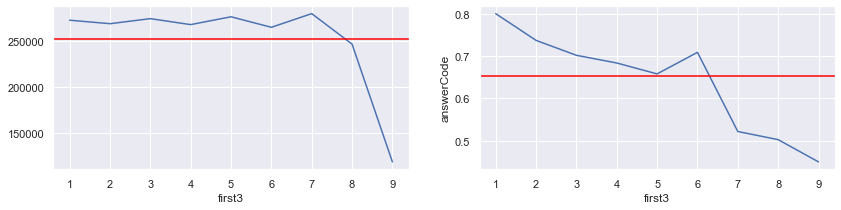

In [12]:
fig = plt.figure(figsize=(14,3))
plt.subplot(1,2,1)
sns.lineplot(df.value_counts("first3"))
plt.axhline(df.value_counts("first3").mean(), color="red")
plt.subplot(1,2,2)
sns.lineplot(df.groupby('first3').answerCode.mean().reset_index(), x="first3", y="answerCode")
plt.axhline(df.answerCode.mean(), color="red")


#### first3이 050인 경우를 제외하고 평균 정답률과 반비례함을 볼 수 있었다. 학년 혹은 난이도를 의미한다고 하면 어느정도 설득력이 있어 보인다.

<AxesSubplot: xlabel='month', ylabel='answerCode'>

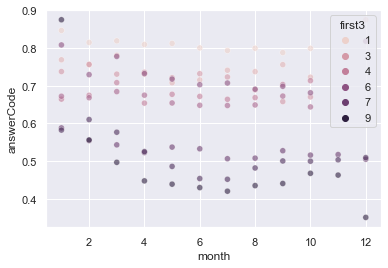

In [13]:
f3_month_df = df.groupby(["first3","month"]).answerCode.mean().reset_index()
sns.scatterplot(f3_month_df,x="month",y="answerCode",hue="first3",alpha=.6)

In [14]:
df.groupby('first3').KnowledgeTag.apply(lambda x:sorted(list(set(x))))

first3
1    [5485, 5814, 5834, 5836, 5844, 5845, 5846, 630...
2    [7693, 7694, 7696, 7747, 7751, 7822, 7912, 791...
3    [307, 308, 309, 331, 332, 334, 339, 342, 346, ...
4    [2047, 2048, 2049, 2050, 2053, 2054, 2055, 206...
5    [192, 202, 360, 374, 392, 393, 394, 395, 396, ...
6    [586, 587, 588, 589, 590, 592, 593, 594, 595, ...
7    [116, 117, 121, 162, 163, 164, 169, 607, 608, ...
8    [23, 24, 25, 26, 30, 31, 32, 1107, 1108, 1110,...
9    [78, 971, 972, 974, 975, 1000, 1002, 1009, 101...
Name: KnowledgeTag, dtype: object

#### KnowledgeTag를 first3 기준으로 묶으면 연속한 범위 내로 묶임을 확인할 수 있었다. first3과 KnowledgeTag로 새로운 카테고리를 만들 수 있지 않을까?
##### 값의 범위가 지정되어 있다는건 거리 기준으로 구분할 수 있을 가능성이 있음을 의미하지 않을까? -> Scaling 후 KMeans clustering으로 구분해 보자.

In [15]:
from sklearn.cluster import KMeans # Kmods Clustering
from sklearn.preprocessing import MinMaxScaler

In [16]:
scaler = MinMaxScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(df[["first3","KnowledgeTag"]]),columns = ["first3","KnowledgeTag"])
cluster = KMeans(n_clusters=44)
cluster.fit(scaled_df)
clu_result = cluster.predict(scaled_df)
df["first3_tag_clu"] = clu_result

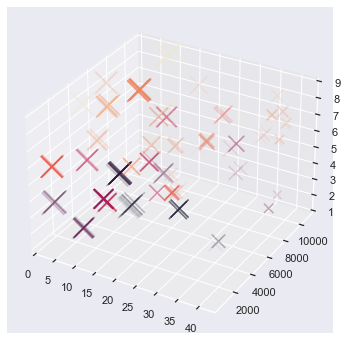

In [17]:
sns.set(style="darkgrid")
plt.figure(figsize=(6,6))
ax = plt.axes(projection='3d')
f3_tag_clu_df = df[["first3","KnowledgeTag","first3_tag_clu"]].drop_duplicates()
x=f3_tag_clu_df.first3_tag_clu.values
y=f3_tag_clu_df.KnowledgeTag.values
z=f3_tag_clu_df.first3.values
ax.set_xlim(xmin=x.min(),xmax=x.max())
ax.set_ylim(ymin=y.min(),ymax=y.max())
ax.set_zlim(zmin=z.min(),zmax=z.max())
ax.scatter3D(x,y,z, marker='x', s=(50-x)*10, c=z, alpha=.05)
# sns.scatterplot(df[["first3","KnowledgeTag","first3_tag_clu"]],x="first3_tag_clu",y="KnowledgeTag",hue="first3")

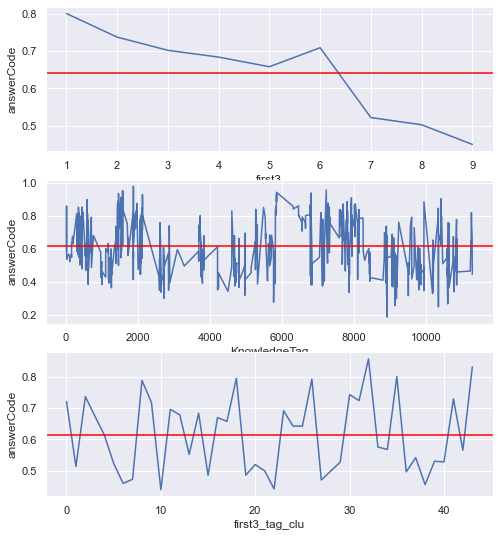

In [18]:
fig = plt.figure(figsize=(8,9))
plt.subplot(3,1,1)
sns.lineplot(df.groupby("first3").answerCode.agg("mean"))
plt.axhline(df.groupby("first3").answerCode.agg("mean").mean(),color="red")
plt.subplot(3,1,2)
sns.lineplot(df.groupby("KnowledgeTag").answerCode.agg("mean"))
plt.axhline(df.groupby("KnowledgeTag").answerCode.agg("mean").mean(),color="red")
plt.subplot(3,1,3)
sns.lineplot(df.groupby("first3_tag_clu").answerCode.agg("mean"))
plt.axhline(df.groupby("first3_tag_clu").answerCode.agg("mean").mean(),color="red")

#### KnowledgeTag와 first3을 군집화하여 정답률을 plot해본 결과, 정답률이 높은경우와 낮은 경우가 조금 더 구분되어 있다.
#### 수학을 예시로 결과에 대해 예상해보면 학년마다 배우는 과목은 덧셈, 뺄셈같이 난이도가 낮은 분야가 있고 미분, 적분, 확률, 통계, 기하와 벡터처럼 난이도가 높은 분야가 있다.
#### 덧셈, 뺄셈, 곱셈, 나눗셈, 행렬, 미적분, 통계, 벡터 등 모든 소분류가 KnowledgeTag로 나타내어져 있고 학년이 first3으로 나타내어져 있다고 가정해 보자.
#### 클러스터링을 통해 사칙연산, 수1, 수2, 기하와 벡터, 미적분, 확률과 통계로 대분류가 구분되어져 정답률의 평균값이 상-하로 나뉘어졌다고 군집화 결과를 해석할 수 있지 않을까?

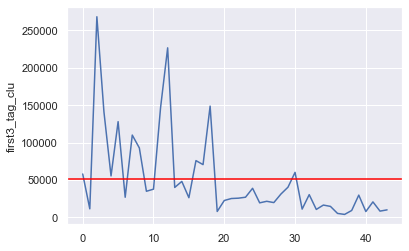

In [19]:
sns.lineplot(df["first3_tag_clu"].value_counts())
plt.axhline(df["first3_tag_clu"].value_counts().mean(), color="red")

<AxesSubplot: xlabel='answerCode', ylabel='Count'>

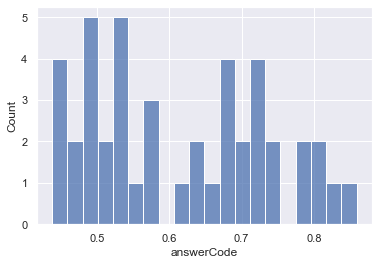

In [20]:
clu_mean = df.groupby("first3_tag_clu").answerCode.mean()
sns.histplot(clu_mean, bins=20, stat='count')

#### 어느정도 구분이 된 모습이지만 명확한 구분 기준을 확신할 순 없었다. feature로 사용해 보고 의미있는지 확인해 볼 필요가 있어 보인다.

# 2. mid3

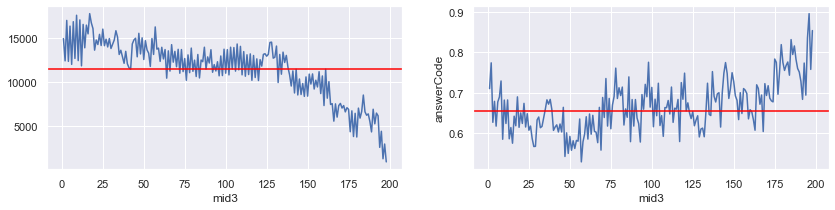

In [22]:
fig = plt.figure(figsize=(14,3))
plt.subplot(1,2,1)
sns.lineplot(df.value_counts("mid3"))
plt.axhline(df.value_counts("mid3").mean(), color="red")
plt.subplot(1,2,2)
sns.lineplot(df.groupby('mid3').answerCode.mean().reset_index(), x="mid3", y="answerCode")
plt.axhline(df.answerCode.mean(), color="red")

### 198개의 카테고리로 구분되는 mid3이 mid3의 값과 데이터 개수가 반비례함을 보인다.

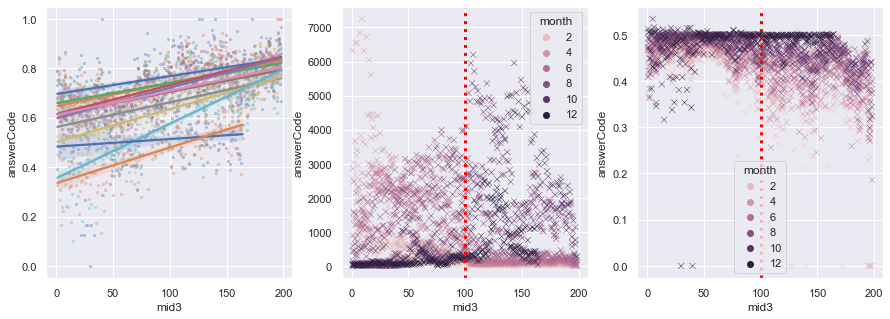

In [65]:
month_mid3_rate = df.groupby(["month","mid3"]).answerCode.mean().reset_index()
month_mid3_count = df.groupby(["month","mid3"]).answerCode.count().reset_index()
month_mid3_std = df.groupby(["month","mid3"]).answerCode.std().reset_index()
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
# sns.scatterplot(month_mid3_rate,x="mid3",y="answerCode",hue="month",marker='x')
m3_month = df[["mid3","answerCode","month"]].groupby(["mid3","month"]).answerCode.mean().reset_index()
for m in range(1,13):
    sns.regplot(
        data=m3_month[m3_month.month==m],
        x="mid3",
        y="answerCode",
        scatter_kws={'marker':'x','s':5,'alpha':0.3})
plt.subplot(1,3,2)
sns.scatterplot(month_mid3_count,x="mid3",y="answerCode",hue="month",marker='x')
plt.axvline(x=100, color='red',linestyle=":",linewidth=3)
plt.subplot(1,3,3)
sns.scatterplot(month_mid3_std,x="mid3",y="answerCode",hue="month",marker='x')
plt.axvline(x=100, color='red',linestyle=":",linewidth=3)


#### 월 별 mid3의 개수와 정답률이 유의미한 관계가 있음을 확인할 수 있다.
- mid3이 출간된 순서대로 시험지들에 매겨진 출간번호라면? -> season을 의미할 수 있다. 
- 우측 그래프에서 상반기엔 mid3이 작은 문제지가, 하반기엔 mid3이 큰 문제지가 많이 사용되고 있다.
- mid3별 데이터의 count value 또한 설명된다. 출간 번호는 1부터 매겨지므로 반비례할 수 있다.

<AxesSubplot: >

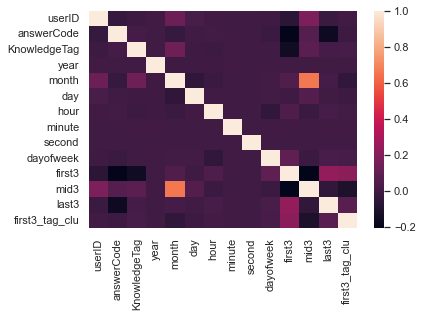

In [24]:
sns.heatmap(df.corr())

#### mid3과 month의 상관관계 또한 0.7정도로 높게 측정되었다.

# 3. Last3

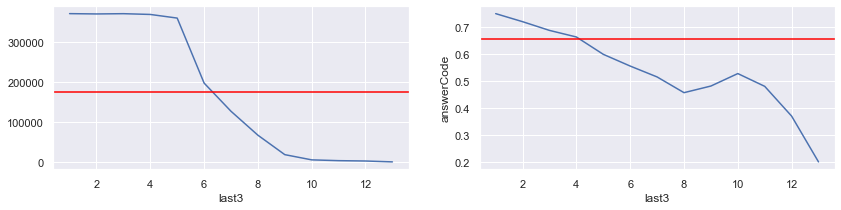

In [25]:
fig = plt.figure(figsize=(14,3))
plt.subplot(1,2,1)
sns.lineplot(df.value_counts("last3"))
plt.axhline(df.value_counts("last3").mean(), color="red")
plt.subplot(1,2,2)
sns.lineplot(df.groupby('last3').answerCode.mean().reset_index(), x="last3", y="answerCode")
plt.axhline(df.answerCode.mean(), color="red")

#### last3의 경우 testId에 없고 assessmentItemID엔 있는 데이터이다. 시험지의 문항번호라고 가정하면 count와 반비례하는것도, 난이도와 반비례하는것도 설명 가능하다.
- 대부분의 시험지는 5문항 미만으로 구성되어 있으며 최대 13문제까지 있다.
- 문항 수가 적을수록 평균 정답률이 높다.
- 사용자가 시험지를 푸는 시간은 구성 문제 수와 비례하는가?

In [26]:
def time_diff(x):
    return (x[-1]-x[0]).total_seconds()
test_time = df.groupby(["userID","testId"]).datetime.apply(lambda x:time_diff(list(x))).reset_index()
test_time.columns = ["userID","testId","test_elapse"]
df = pd.merge(df,test_time, how="left", on=["userID","testId"])

In [27]:
df.loc[df.test_elapse>2*60*60,"test_elapse"]=np.nan
test_time_mean = df.groupby("testId").test_elapse.median().to_dict()
df.loc[df.test_elapse.isna(),"test_elapse"]=df.loc[df.test_elapse.isna(),"testId"].map(test_time_mean)

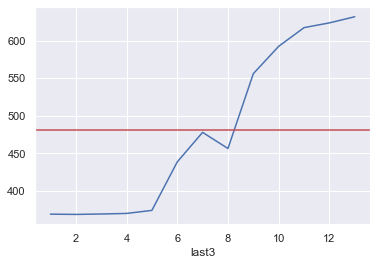

In [28]:
df.groupby("last3").test_elapse.mean().plot()
plt.axhline(df.groupby("last3").test_elapse.mean().mean(),color='r')

#### 이상치를 제외 last3 별 소요시간을 확인한 결과 문항 수가 많으면 소요 시간이 늘어남을 확인할 수 있었다.
- last3이 8인 경우에만 조금 다른 양상을 띄고 있다. 원인을 추적해 볼 필요가 있다.

# KnowledgeTag

<AxesSubplot: xlabel='KnowledgeTag', ylabel='answerCode'>

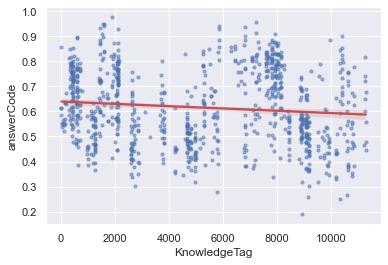

In [29]:
sns.regplot(
    df.groupby("KnowledgeTag").answerCode.mean().reset_index(),
    x="KnowledgeTag",
    y="answerCode",
    scatter_kws={
        's':10,
        'alpha':0.5,
    },
    line_kws={'color':'r'}
)

#### 정답률과 KnowledgeTag 사이에 유의미한 관계가 있어 보이진 않는다.

<AxesSubplot: xlabel='KnowledgeTag', ylabel='first3'>

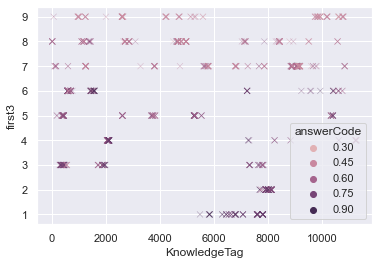

In [77]:
sns.scatterplot(
    data=df.groupby(["KnowledgeTag","first3"]).answerCode.mean().reset_index(),
    x="KnowledgeTag",
    y="first3",
    hue="answerCode",
    alpha=0.5,
    marker='x'
)

#### first3과 KnowledgeTag가 작으면 정답률이 높은 경향이 있지만 명확히 구분되지는 않는다.

<AxesSubplot: xlabel='KnowledgeTag', ylabel='var'>

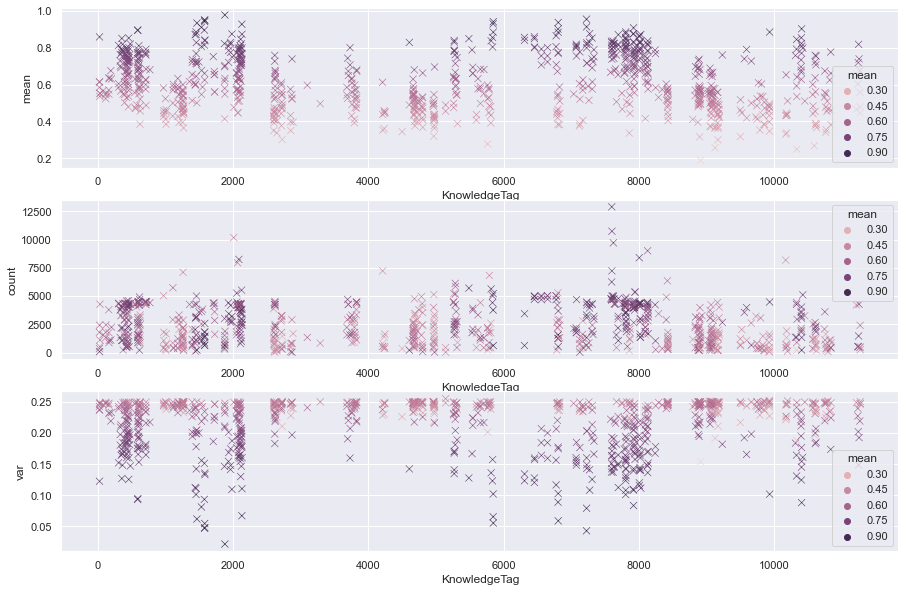

In [173]:
tags = df.groupby("KnowledgeTag").answerCode.agg(["mean","count","var"]).reset_index()
plt.figure(figsize=(15,10))
plt.subplot(3,1,1)
sns.scatterplot(tags,x="KnowledgeTag",y="mean",hue="mean",marker='x',s=50)
plt.subplot(3,1,2)
sns.scatterplot(tags,x="KnowledgeTag",y="count",hue="mean",marker='x',s=50)
plt.subplot(3,1,3)
sns.scatterplot(tags,x="KnowledgeTag",y="var",hue="mean",marker='x',s=50)


In [139]:
df["elapse"] = (df.shift(-1).datetime - df.datetime).apply(lambda x:x.total_seconds())
df.loc[df.userID!=df.shift(-1).userID,"elapse"] = np.nan
df.loc[df.elapse>60*60,"elapse"]=np.nan
els_median = df.groupby("testId").elapse.median().to_dict()
df.loc[df.elapse.isna(),"elapse"]=df.loc[df.elapse.isna(),"testId"].map(els_median)

<AxesSubplot: xlabel='KnowledgeTag', ylabel='elapse'>

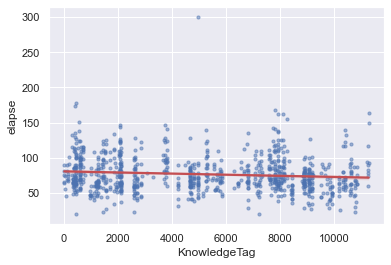

In [150]:
sns.regplot(
    df.groupby("KnowledgeTag").elapse.mean().reset_index(),
    x="KnowledgeTag",
    y="elapse",
    scatter_kws={
        's':10,
        'alpha':0.5,
    },
    line_kws={'color':'r'}
)

#### elapse와 KnowledgeTag 사이 관계 또한 무의미해 보인다.

### KnowledgeTag가 비슷한 문제들을 비슷한 값으로 나타내고 있다는 생각은 들지만 그 값 자체가 갖는 의미는 없는것 같다.

# month

([<matplotlib.patches.Wedge at 0x30bae87c0>,
 [Text(1.098523402697154, 0.05697660683707331, '1'),
  Text(1.0749547909650234, 0.23339279633558302, '2'),
  Text(0.9285756254179086, 0.589701032625635, '3'),
  Text(0.5445533033775476, 0.9557519028391211, '4'),
  Text(0.019631936206838403, 1.0998247983568887, '5'),
  Text(-0.5770442888307813, 0.9364934002585272, '6'),
  Text(-1.0412833656087326, 0.35458278653447173, '7'),
  Text(-0.9731419088477765, -0.5128302109315577, '8'),
  Text(-0.19412717375315516, -1.0827347968965495, '9'),
  Text(0.7468831870694973, -0.8075676472425765, '10'),
  Text(1.0597082662362456, -0.29498879719503035, '11'),
  Text(1.095928933115223, -0.09455037578417562, '12')],
 [Text(0.5991945832893567, 0.031078149183858168, '1.6%'),
  Text(0.5863389768900128, 0.12730516163759073, '3.5%'),
  Text(0.5064957956824956, 0.3216551087048918, '7.7%'),
  Text(0.29702907456957134, 0.5213192197304296, '7.8%'),
  Text(0.010708328840093673, 0.5999044354673938, '8.1%'),
  Text(-0.31475

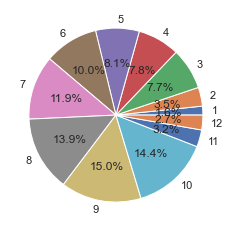

In [212]:
# 2266586
month_count = df.month.value_counts().reset_index()
month_count.columns = ["month","ratio"]
month_count.ratio = month_count.ratio/2266586
month_count.sort_values(["month"],inplace=True)
plt.pie(month_count.ratio, labels=month_count.month, autopct='%.1f%%')

### 월 별 데이터 개수가 상당한 차이를 보이고 있다. 11~2월은 특히 눈에띄게 적은 양의 데이터가 존재함을 확인할 수 있다. 종강(방학) 시즌을 나누는게 의미있어 보인다.

In [216]:
df["vacation"] = df.month.apply(lambda x:x in (1,2,11,12)).astype(int)

In [217]:
month_mean = df.groupby("month").agg({
    "elapse":"mean",
    "answerCode":"mean"
}).reset_index()
month_var = df.groupby("month").agg({
    "elapse":"var",
    "answerCode":"var"
}).reset_index()

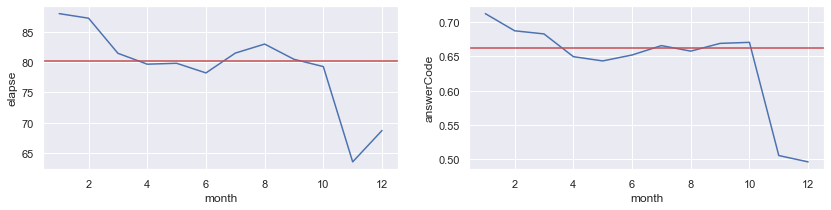

In [218]:
plt.figure(figsize=(14,3))

plt.subplot(1,2,1)
sns.lineplot(month_mean, x='month',y='elapse')
plt.axhline(month_mean.elapse.median(), c='r')

plt.subplot(1,2,2)
sns.lineplot(month_mean, x='month',y='answerCode')
plt.axhline(month_mean.answerCode.median(), c='r')

#### 정답률, elapse와 month 사이의 경향성이 비슷하다는 점을 제외하고 다른 정보를 얻긴 힘들었다.
#### 다만, 11월과 12월의 정답률과 elapse가 굉장히 낮음을 볼 수 있다. 

In [239]:
df[df.month.isin([11,12])].first3.unique()

array([8, 9, 7, 2, 6])

### 11,12 월의 특징을 찾기위해 11,12월에 해당하는 정보를 확인해 보았다. 해당 구간엔 first3이 2, 6~9 인 경우만이 존재하였다.

<AxesSubplot: xlabel='first3', ylabel='count'>

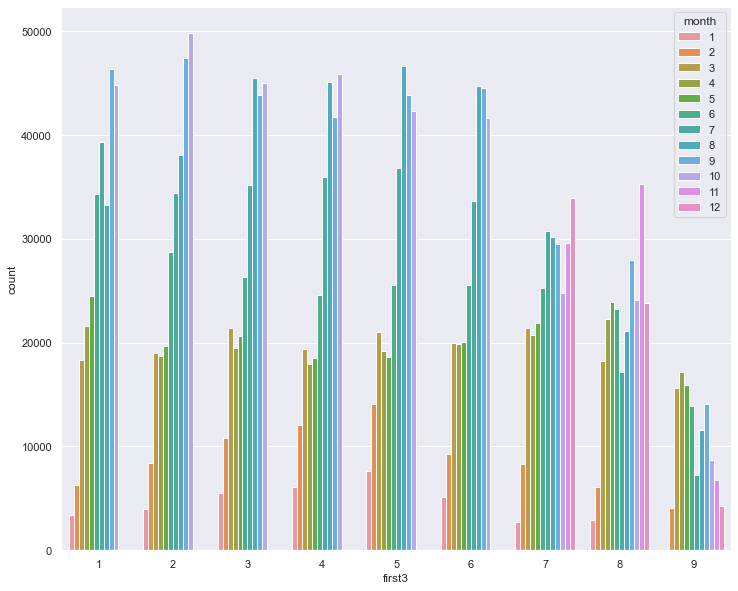

In [256]:
plt.figure(figsize=(12,10))
sns.countplot(df, x="first3", hue="month")

### first3이 7,8,9인 경우는 월말이 대부분을 차지함을 발견했다. first3을 학년보단 난이도 개념으로 봐야할 듯 하다.

<AxesSubplot: xlabel='first3', ylabel='answerCode'>

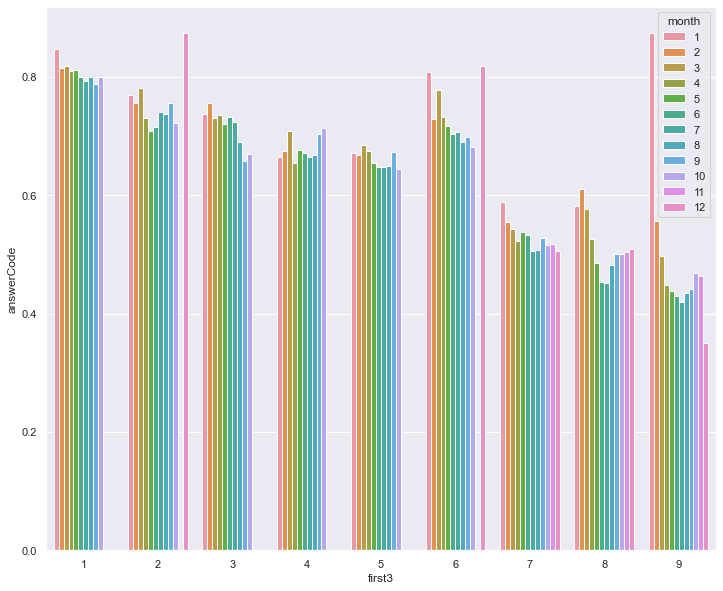

In [260]:
plt.figure(figsize=(12,10))
f3_month_rate = df.groupby(["first3","month"]).answerCode.mean().reset_index()
sns.barplot(f3_month_rate, x="first3",hue="month",y="answerCode")

In [267]:
df.value_counts("userID").describe()

count    6698.000000
mean      338.397432
std       321.331429
min         9.000000
25%        78.000000
50%       231.500000
75%       513.000000
max      1860.000000
dtype: float64

In [269]:
df.groupby("userID").answerCode.mean().describe()

count    6698.000000
mean        0.628909
std         0.159639
min         0.000000
25%         0.527273
50%         0.651757
75%         0.751203
max         1.000000
Name: answerCode, dtype: float64

In [270]:
df.answerCode.mean()

0.654378435232548

In [273]:
user_count = df.value_counts("userID").reset_index()
user_count.columns = ["userID", "user_solved_count"]
user_count

,userID,user_solved_count
0,730,1860
1,481,1847
2,1112,1777
3,394,1774
4,926,1773
...,...,...
6693,7396,14
6694,7414,13
6695,7390,13
6696,7252,13


In [277]:
user_mean = df.groupby("userID").answerCode.mean().reset_index()
user_mean.columns = ["userID", "userID_answerCode_mean"]
user_mean

,userID,userID_answerCode_mean
0,0,0.630872
1,1,0.853162
2,2,0.612319
3,5,0.795918
4,6,0.442997
...,...,...
6693,7436,0.466667
6694,7437,0.375000
6695,7438,0.750000
6696,7440,0.400000


<AxesSubplot: xlabel='user_solved_count', ylabel='userID_answerCode_mean'>

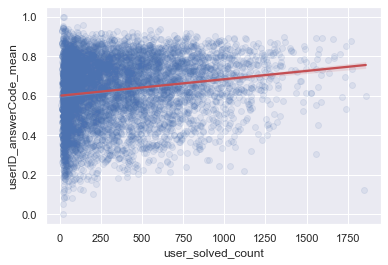

In [297]:
sns.regplot(
    pd.merge(user_count, user_mean, how="left",on="userID").drop("userID",axis=1),
    x="user_solved_count",
    y="userID_answerCode_mean",
    scatter_kws={
        "alpha":.1
    },
    line_kws={
        "color":"r"
    }
)

In [306]:
df[((df.first3.isin([2,6])) & (df.month==12))|((df.first3==9) & (df.month==1))].userID.unique()


array([  92,  784,  883, 2161, 2420])

In [314]:
df[df.userID.isin([92,784,883,2161,2420])].groupby("userID").first3.mean()

userID
92      3.812950
784     3.852615
883     6.230986
2161    8.981777
2420    7.506173
Name: first3, dtype: float64

In [315]:
df[((df.first3.isin([2,6])) & (df.month==12))]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,datetime,year,month,day,...,minute,second,dayofweek,first3,mid3,last3,first3_tag_clu,test_elapse,elapse,vacation
69406,92,A020036001,A020000036,1,2019-12-31 23:17:24,7696,2019-12-31 23:17:24,2019,12,31,...,17,24,1,2,36,1,2,437.0,26.0,1
69407,92,A020036002,A020000036,1,2019-12-31 23:17:50,7696,2019-12-31 23:17:50,2019,12,31,...,17,50,1,2,36,2,2,437.0,22.0,1
69408,92,A020036003,A020000036,1,2019-12-31 23:18:12,7696,2019-12-31 23:18:12,2019,12,31,...,18,12,1,2,36,3,2,437.0,41.0,1
69409,92,A020036004,A020000036,1,2019-12-31 23:18:53,7696,2019-12-31 23:18:53,2019,12,31,...,18,53,1,2,36,4,2,437.0,107.0,1
69410,92,A020036005,A020000036,1,2019-12-31 23:20:40,7696,2019-12-31 23:20:40,2019,12,31,...,20,40,1,2,36,5,2,437.0,95.0,1
69411,92,A020036007,A020000036,1,2019-12-31 23:22:15,7696,2019-12-31 23:22:15,2019,12,31,...,22,15,1,2,36,7,2,437.0,88.0,1
69412,92,A020036008,A020000036,1,2019-12-31 23:23:43,7696,2019-12-31 23:23:43,2019,12,31,...,23,43,1,2,36,8,2,437.0,58.0,1
69413,92,A020036009,A020000036,0,2019-12-31 23:24:41,7696,2019-12-31 23:24:41,2019,12,31,...,24,41,1,2,36,9,2,437.0,31.0,1
555508,784,A060014001,A060000014,1,2019-12-31 15:08:01,7229,2019-12-31 15:08:01,2019,12,31,...,8,1,1,6,14,1,26,88.0,20.0,1
555509,784,A060014002,A060000014,1,2019-12-31 15:08:21,7229,2019-12-31 15:08:21,2019,12,31,...,8,21,1,6,14,2,26,88.0,34.0,1


In [316]:
df[((df.first3.isin([9])) & (df.month==1))]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,datetime,year,month,day,...,minute,second,dayofweek,first3,mid3,last3,first3_tag_clu,test_elapse,elapse,vacation
619705,883,A090001001,A090000001,1,2020-01-30 08:37:41,4697,2020-01-30 08:37:41,2020,1,30,...,37,41,3,9,1,1,22,120.0,20.0,1
619706,883,A090001002,A090000001,1,2020-01-30 08:38:01,4697,2020-01-30 08:38:01,2020,1,30,...,38,1,3,9,1,2,22,120.0,18.0,1
619707,883,A090001003,A090000001,1,2020-01-30 08:38:19,10174,2020-01-30 08:38:19,2020,1,30,...,38,19,3,9,1,3,10,120.0,31.0,1
619708,883,A090001004,A090000001,1,2020-01-30 08:38:50,78,2020-01-30 08:38:50,2020,1,30,...,38,50,3,9,1,4,27,120.0,9.0,1
619709,883,A090001005,A090000001,1,2020-01-30 08:38:59,78,2020-01-30 08:38:59,2020,1,30,...,38,59,3,9,1,5,27,120.0,16.0,1
619710,883,A090001006,A090000001,1,2020-01-30 08:39:15,78,2020-01-30 08:39:15,2020,1,30,...,39,15,3,9,1,6,27,120.0,11.0,1
619711,883,A090001007,A090000001,1,2020-01-30 08:39:26,4697,2020-01-30 08:39:26,2020,1,30,...,39,26,3,9,1,7,22,120.0,15.0,1
619712,883,A090001008,A090000001,0,2020-01-30 08:39:41,4697,2020-01-30 08:39:41,2020,1,30,...,39,41,3,9,1,8,22,120.0,12.0,1
1333393,2161,A090002001,A090000002,1,2020-01-29 05:42:49,4699,2020-01-29 05:42:49,2020,1,29,...,42,49,2,9,2,1,22,758.0,145.0,1
1333394,2161,A090002002,A090000002,0,2020-01-29 05:45:14,78,2020-01-29 05:45:14,2020,1,29,...,45,14,2,9,2,2,27,758.0,245.0,1


In [324]:
df[df.userID.isin([92,784])].first3.value_counts()

6    720
5    588
1    542
2    385
Name: first3, dtype: int64

In [322]:
df[df.userID.isin([883,2161,2420])].first3.value_counts()

9    1093
7     243
1     230
3      61
8       8
Name: first3, dtype: int64

In [337]:
df.groupby("userID").first3.agg(pd.Series.mode)

userID
0       8
1       4
2       3
5       8
6       3
       ..
7436    3
7437    6
7438    8
7440    3
7441    3
Name: first3, Length: 6698, dtype: object

<AxesSubplot: xlabel='first3', ylabel='answerCode'>

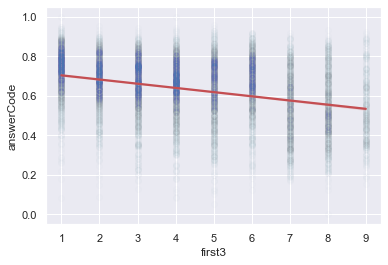

In [353]:
rate = df.groupby("userID").answerCode.mean().reset_index()
mode = df.groupby("userID").first3.apply(lambda x:pd.Series.mode(x)[0])
user_stat = pd.merge(rate, mode, how="left",on="userID")
sns.regplot(
    user_stat,
    x="first3",
    y="answerCode",
    scatter_kws={
        "alpha":.008,
    },
    line_kws={
        "color":"r"
    }
)

<AxesSubplot: xlabel='first3', ylabel='KnowledgeTag'>

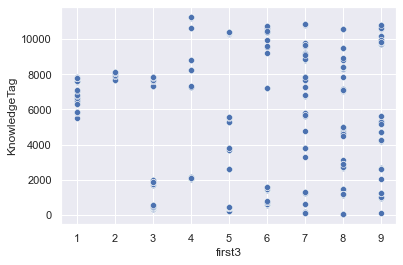

In [355]:
sns.scatterplot(
    df[["first3","KnowledgeTag"]].drop_duplicates(),
    x="first3",
    y="KnowledgeTag")

<AxesSubplot: xlabel='hour', ylabel='test_elapse'>

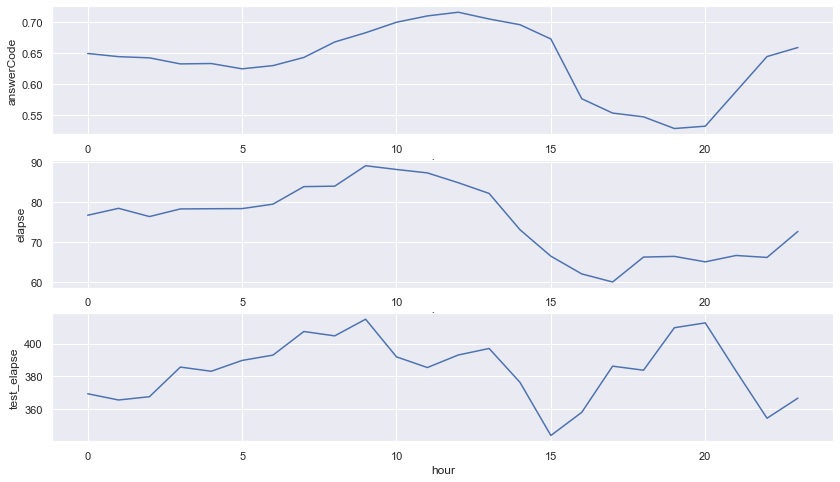

In [368]:
plt.figure(figsize=(14,8))
plt.subplot(3,1,1)
sns.lineplot(df.groupby("hour").answerCode.mean())
plt.subplot(3,1,2)
sns.lineplot(df.groupby("hour").elapse.mean())
plt.subplot(3,1,3)
sns.lineplot(df.groupby("hour").test_elapse.mean())

<AxesSubplot: xlabel='hour', ylabel='count'>

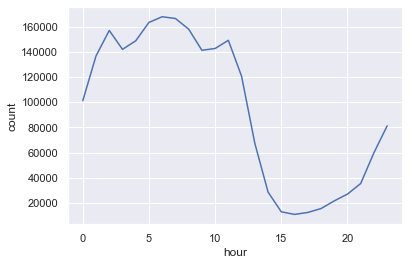

In [373]:
hour_cnt = df.value_counts("hour").reset_index()
hour_cnt.columns = ["hour","count"]
sns.lineplot(
    hour_cnt,
    x="hour",
    y="count"
)

<AxesSubplot: xlabel='month', ylabel='count'>

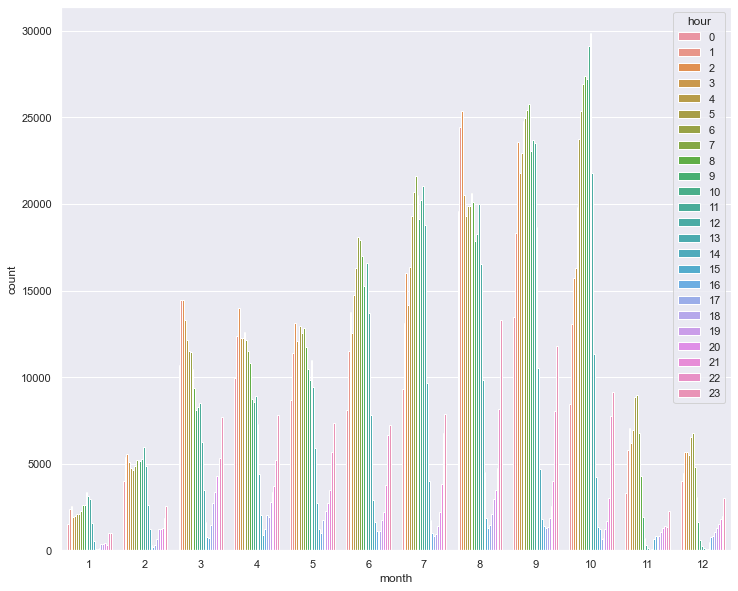

In [381]:
plt.figure(figsize=(12,10))
f3_month_rate = df.groupby(["hour","month"]).Timestamp.count().reset_index()
f3_month_rate.columns = ["hour","month","count"]
sns.barplot(f3_month_rate, x="month",hue="hour",y="count")